# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [234]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
#pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [235]:
noise = .2

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


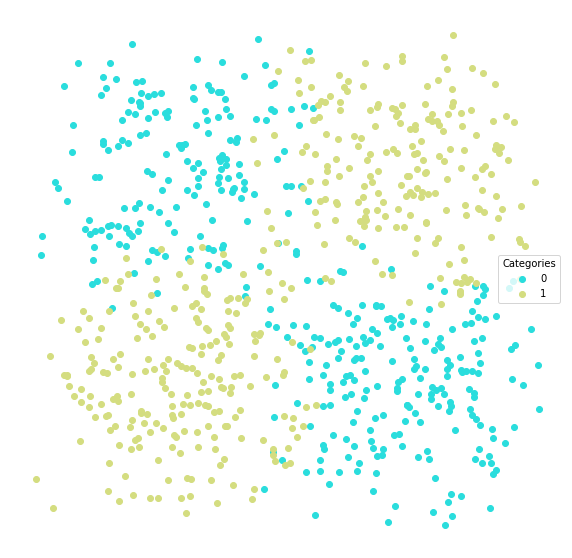

In [236]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [237]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [238]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [239]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.904799,0.929825,0.897405,0.905983
1,0.095,0.904799,0.872093,0.828036,0.903614


This lets us look at which classes do better:

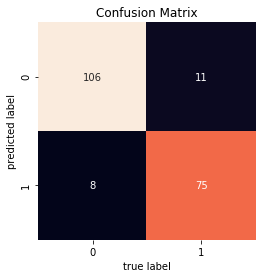

In [240]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

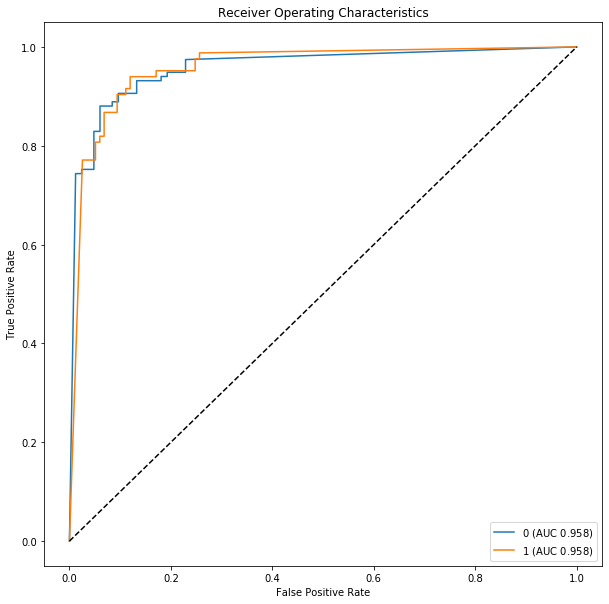

In [241]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


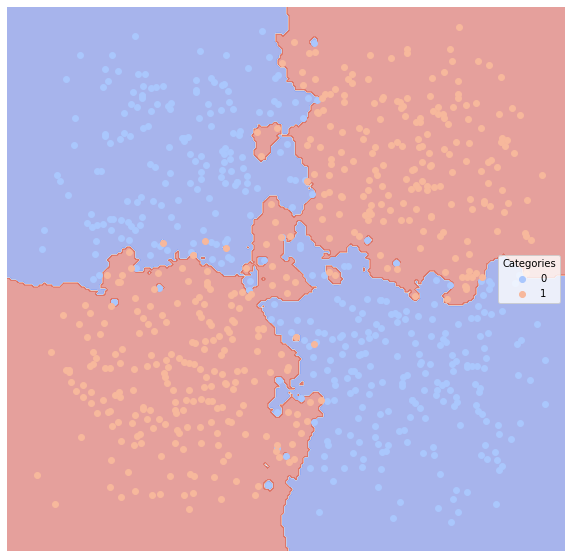

In [242]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [243]:
%%time
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading senate data
Converting to vectors
CPU times: user 5min 17s, sys: 35.3 s, total: 5min 52s
Wall time: 6min 51s


In [244]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [245]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [246]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.134897,0.855672,0.870229,0.778793,0.797203
Clinton,0.134897,0.855672,0.861905,0.837756,0.914141


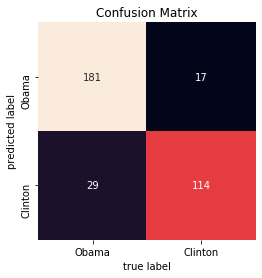

In [247]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

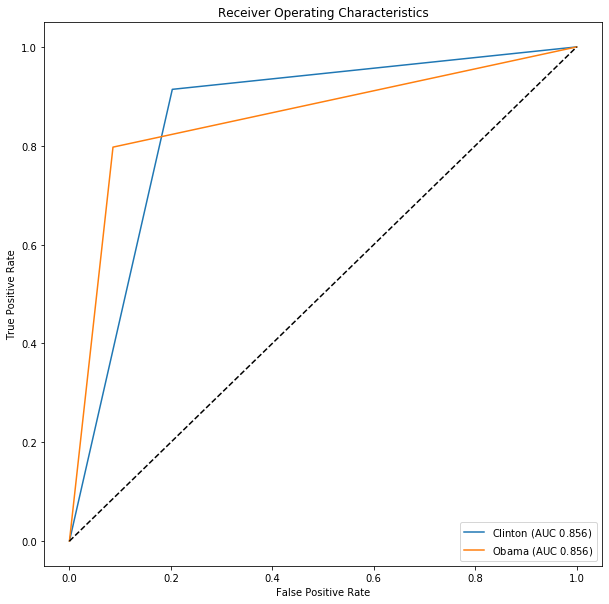

In [248]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


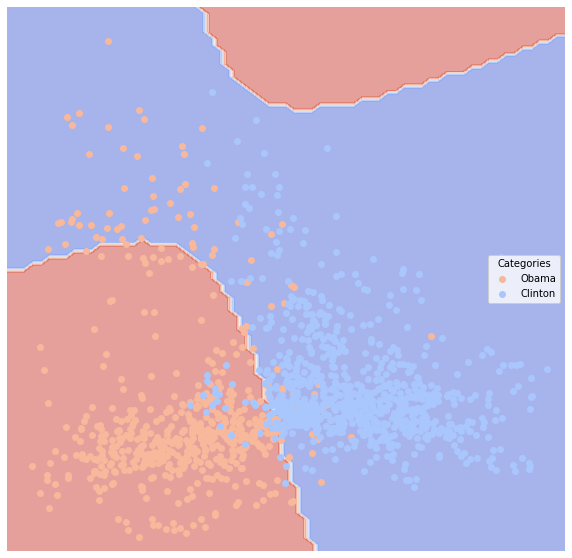

In [249]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

### 10 Artificial Dataset Analysis
- `random` (noise = 0.2): K-nearest-neighbors and Neural Net did the best, but still did pretty badly (KNN makes sense, classifies by finding points close to others) 

- `andSplit` (noise = 0.2): All did fairly well, but Naive Bayes, SVMs (except KNN), logistic regression, Nueral Net and Random Forest did the best 

- `xorSplit` (noise = 0.2): Lots of variability, KNN and linear SVM did particularly well 

- `targetSplit` (noise = 0.2): KNN and Decision trees did well 

- `multiBlobs` (noise = 0.2): Neural Net does well (divides space non-linearly) 

- `random` (noise = 0.5): Same as above, but KNN and Neural Net seem to be overfitting 

- `andSplit` (noise = 0.5): Noise clouds most of the algorithms in general, but above trend seems to hold 

- `xorSplit` (noise = 0.5):  KNN and SVM w. higher degree (I tested 2) did well 

- `targetSplit` (noise = 0.5): Neural Nets did well

- `multiBlobs` (noise = 0.5):  Neural Nets did well 

### 10 Empirical Dataset Analysis 
- The Reddit data performed well w/ most models but linear SVM, Logistic Regression and Neural Nets (3 clusters linearly separable but the last cluster added noise to the class distinction) 

- The Newsgroups were classfieid best by the linear SVM, Logistic Regression, and Neural Nets (some overlap between the "For Sale" and "Mac Hardware" topics) betwen 4 clusters might have confused other alorithms) 

- For the 2 Senator press releases the linear SVM, logistic regression, decision tree, gradient boost, and random forest did well. For the Senate press releases "classified" by Senator (2 senators), again most models performed well for this data (data had only two classes so simple models do best) 

- The larger Senator press releases had 5 classes that were mainly distinct, which lead the more discerning models (random forest, ensemble and gradient boosting) to perform the best

- The spam email data had the most variable results because of the different Ns between the clsses (because we are trying to clearly minimize one category and also there aren't really clear distinctions, Naive Bayes and Neural Network models did well) 

### New Classifier 

In [250]:
new_noise = 0.2
#artificial 
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(new_noise)) 
#empirical 
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

In [251]:
clf = sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=2)

In [252]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [253]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.26,0.73872,0.720430,0.649020,0.720430
1,0.26,0.73872,0.757009,0.703063,0.757009


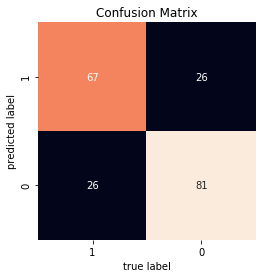

In [254]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

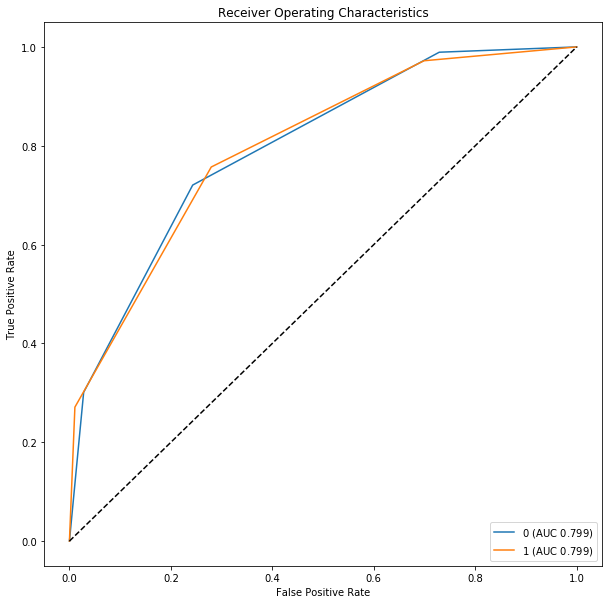

In [255]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


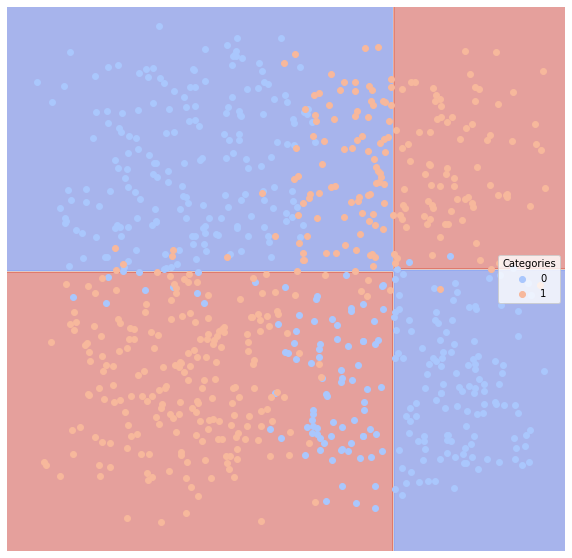

In [256]:
lucem_illud_2020.plotregions(clf, dfTrain)

This slightly different decision tree classifier (I was going for CART but I don't think I got quite there), and it seems to be doing well on the X-split data (with not much noise). The improvement in the classifier's performance is rather stunning though, as in the original run, decision trees didn't perform the best, but with these modifications, the model seems to capture the categories in the dataset very well. 

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [257]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [258]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [259]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [260]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [261]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [262]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [263]:
TFVects.shape

(1368, 11290)

We can save this in the dataframe to make things easier

In [264]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [265]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [266]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


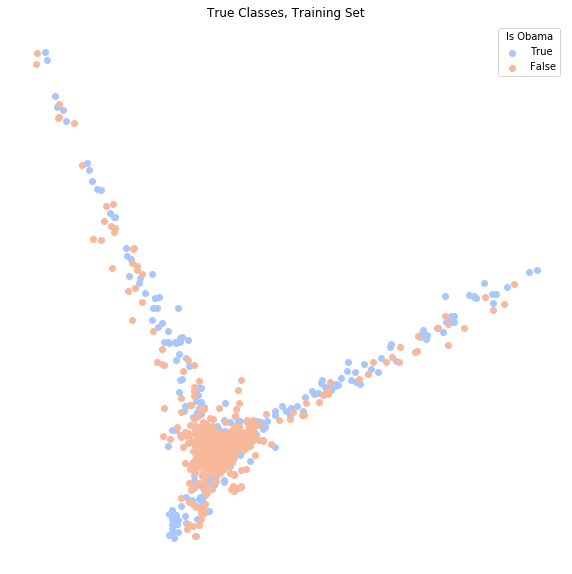

In [267]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

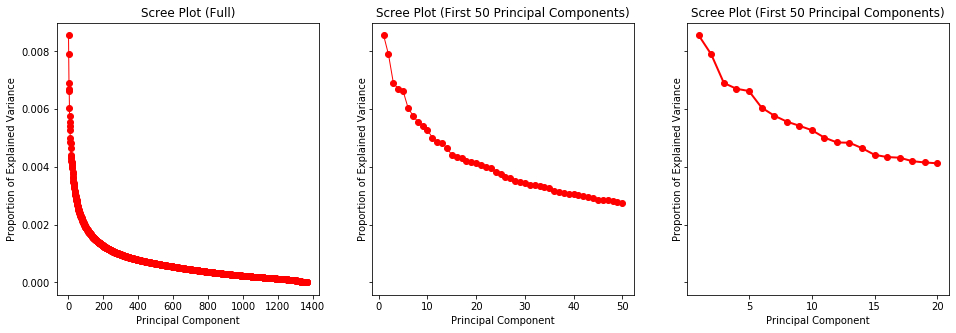

In [268]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [269]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [270]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [271]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6644736842105263

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [272]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6275659824046921

Slightly poorer. How about using more dimensions (40)?

In [273]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7244152046783626
Testing:
0.7155425219941349


Or still more (100)?

In [274]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8486842105263158
Testing:
0.7712609970674487


Or even more (200)!

In [275]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8720760233918129
Testing:
0.7917888563049853


This is becoming ridiculous (400)!

In [276]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9166666666666666
Testing:
0.8152492668621701


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [277]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9612573099415205


Train the model using training data, and then test it on the testing data.

In [278]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8328445747800587


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [279]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [280]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9641812865497076
Testing:
0.8680351906158358


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [281]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [282]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8064516129032258

Recall:

In [283]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8928571428571429

F1-measure:

In [284]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8474576271186439

Let's take a look at how well our posterior distribution looks relative to the truth.

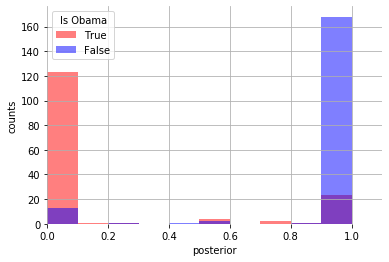

In [285]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [286]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,announcement,-2.285574,labolt,-1.746057
1,fy,-2.322388,5566,-1.777474
2,welcomed,-2.322388,dick,-1.777474
3,awarded,-2.347706,amy,-1.854860
4,ground,-2.360609,monday,-1.866421
5,urging,-2.373681,chicago,-1.926319
6,honor,-2.386926,brundage,-1.938742
7,panel,-2.413955,temporary,-2.177634
8,read,-2.413955,reform,-2.226424
9,entire,-2.427748,practices,-2.260325


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [287]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [288]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [289]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [290]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [291]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [292]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [293]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [294]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8885664538595474


In [295]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
209,talk.religion.misc,talk.religion.misc
1397,sci.space,sci.space
2084,comp.graphics,comp.graphics
719,soc.religion.christian,soc.religion.christian
92,talk.religion.misc,talk.religion.misc
314,talk.religion.misc,talk.religion.misc
60,talk.religion.misc,talk.religion.misc
2132,comp.graphics,comp.graphics
2074,comp.graphics,comp.graphics
359,talk.religion.misc,soc.religion.christian


Looks pretty good, lets examine the testing dataset:

In [296]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7953488372093023


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

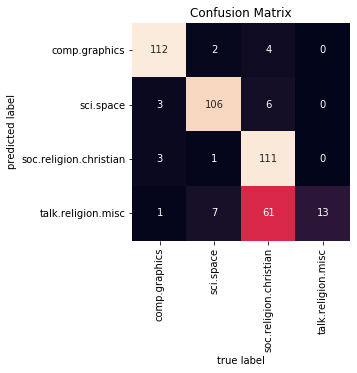

In [297]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [298]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_scoretest_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.9246544941859419
0.7953488372093023
0.8337901094785652


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [299]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.graphics,0.030233,0.963358,0.941176,0.907274,0.949153
sci.space,0.044186,0.944997,0.913793,0.863209,0.921739
soc.religion.christian,0.174419,0.869910,0.609890,0.597979,0.965217
talk.religion.misc,0.160465,0.579268,1.000000,0.319002,0.158537


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

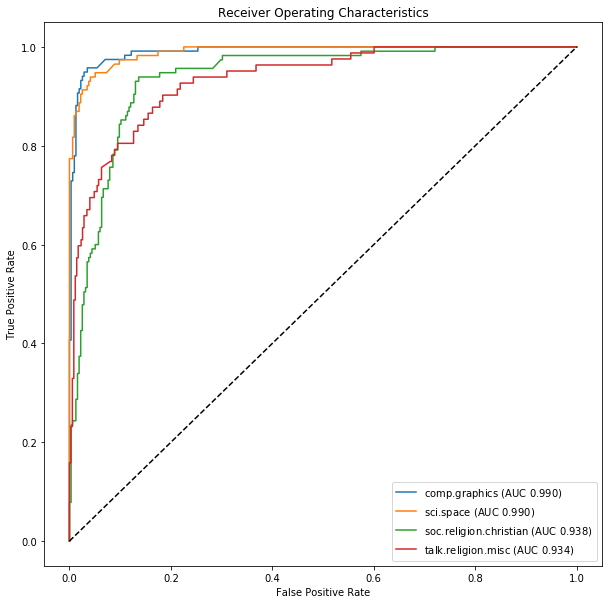

In [300]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

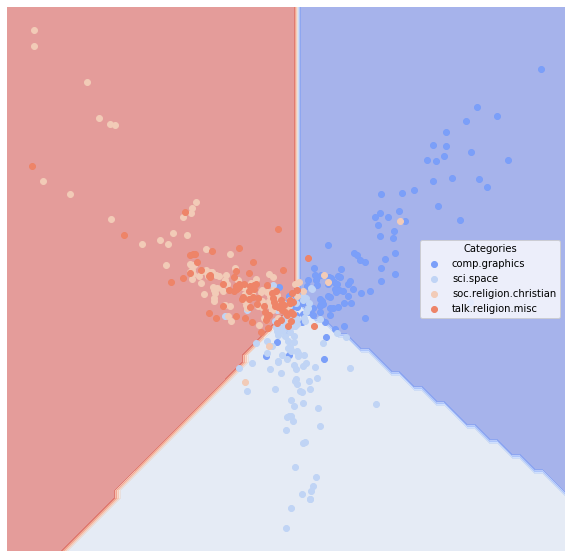

In [301]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [302]:
# my project is taking some time to set up, so I'll do this on a practice dataset of friends scripts 
import csv
import pandas as pd
df = pandas.read_csv("friends.csv", sep=';', header=0)
df.head()

,season,episodeNum,person,line
0,1,1,monica,there's nothing to tell! he's just some guy i...
1,1,1,joey,"c'mon, you're going out with the guy! there's..."
2,1,1,chandler,"all right joey, be nice. so does he have a h..."
3,1,1,phoebe,"wait, does he eat chalk?"
4,1,1,phoebe,"just, 'cause, i don't want her to go through ..."


In [303]:
df = df.astype({"season": int, "episodeNum": int, "person": str, "line":str})

In [304]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(df, holdBackFraction=holdBackFraction)

In [307]:
# Tokenize and Normalize
df['tokenized_text'] = df['line'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df['normalized_text'] = df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [308]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(df['line'])

In [ ]:
lucem_illud_2020.plotter(train_data_df)

#### Logistic Regression

In [ ]:
clf = sklearn.linear_model.LogisticRegression()

In [ ]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df['person'])

In [ ]:
# Save Predictions
train_data_df['lr_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

In [ ]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['lr_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotregions(clf, test_data_df)

#### Naive Bayes 

In [ ]:
clf = sklearn.naive_bayes.MultinomialNB()

In [ ]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df['person'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotregions(clf, test_data_df)

I don't have any uncoded data in this toy dataset, but it seems like naive bayes does better in classifying speakers. Logistic regression algorithms are best with linearly seperable data, we know, and with five main speakers (plus the grab-bag "other" category), this is not a dataset that is amenable to binary classification. 

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification: 

In [ ]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

#### Decision Tree

In [ ]:
clf = sklearn.tree.DecisionTreeClassifier()

In [ ]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

In [ ]:
# Save Predictions
train_data_df['dt_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))

In [ ]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['dt_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotregions(clf, test_data_df)

#### Random Forest 

In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()

In [ ]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

In [ ]:
train_data_df['bagtree_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]
test_data_df['bagtree_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

In [ ]:
test_data_df.groupby('rf_predict').size()

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotregions(clf, test_data_df)

The random forest ensemble seems to perform better than the decision tree in terms of recall, which is to be expected as ensemble methods tend to be more robust than a single decision tree. 

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

In [ ]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

In [ ]:
train_data_df['knn_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['knn_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotregions(clf, test_data_df)

K-means clustering is an unsupervised algorithm, and KNN is supervised (meaning it needs labelled data like the above to train on). KNN will give new data points given the "k nearest neighbors" (i.e. its used in classification and regression) while k-means clustering will separate the data into k clusters. 

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [ ]:
clf = sklearn.neural_network.MLPClassifier()

In [ ]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

In [ ]:
# Save Predictions
train_data_df['nn_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))

#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['nn_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

In [ ]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [ ]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['nn_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'nn_predict']]

The neural net appears to have about the same recall as the KNN, and decision tree approaches, and does better than the Naive Bayes, and logistic regression models. This may be due to the number of classes (5), which is a bit higher than the examples'. With a higher number of classes, more fine-grained algorithms would be more successful, although there is a danger of overfitting. 